
# 🎯 Objetivo: Detectar toxicidad con datos aumentados

## 📋 Estrategia:
### - Eliminar columnas desbalanceadas
### - Aplicar Data Augmentation con traducción
### - Preprocesar texto eficientemente
### - Entrenar XGboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Procesamiento de texto
import re
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score 
import xgboost as xgb

# Para augmentación simple
import random
from textblob import TextBlob

# Persistencia
import pickle
from datetime import datetime

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Cargar datos y análisis inicial

In [2]:

df = pd.read_csv('../data/youtoxic_english_1000.csv')
print(f"✅ Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")

# Columnas de toxicidad
columnas_toxicidad = ['IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 
                      'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 
                      'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']



✅ Dataset original: 1000 filas, 15 columnas


# 2. IDENTIFICAR Y ELIMINAR COLUMNAS DESBALANCEADAS=

In [3]:
print("\n🔍 Analizando balance de columnas...")

# Calcular balance
balance = {}
UMBRAL = 5.0  # 5% mínimo

for col in columnas_toxicidad:
    porcentaje = (df[col].sum() / len(df)) * 100
    balance[col] = porcentaje
    estado = "✅ Mantener" if porcentaje >= UMBRAL else "❌ Eliminar"
    print(f"{col:20} -> {porcentaje:5.1f}% {estado}")

# Seleccionar solo columnas balanceadas
columnas_mantener = [col for col in columnas_toxicidad if balance[col] >= UMBRAL]
columnas_eliminar = [col for col in columnas_toxicidad if balance[col] < UMBRAL]

print(f"\n📊 Resumen:")
print(f"   - Columnas a mantener: {len(columnas_mantener)}")
print(f"   - Columnas a eliminar: {len(columnas_eliminar)}")

# Crear etiqueta binaria solo con columnas balanceadas
df['toxic_binary'] = (df[columnas_mantener].sum(axis=1) > 0).astype(int)

# Eliminar columnas desbalanceadas del dataset
df = df.drop(columns=columnas_eliminar)

print(f"\n✅ Nueva distribución de toxicidad:")
print(df['toxic_binary'].value_counts())
print(f"Porcentaje tóxico: {df['toxic_binary'].mean()*100:.1f}%")


🔍 Analizando balance de columnas...
IsAbusive            ->  35.3% ✅ Mantener
IsThreat             ->   2.1% ❌ Eliminar
IsProvocative        ->  16.1% ✅ Mantener
IsObscene            ->  10.0% ✅ Mantener
IsHatespeech         ->  13.8% ✅ Mantener
IsRacist             ->  12.5% ✅ Mantener
IsNationalist        ->   0.8% ❌ Eliminar
IsSexist             ->   0.1% ❌ Eliminar
IsHomophobic         ->   0.0% ❌ Eliminar
IsReligiousHate      ->   1.2% ❌ Eliminar
IsRadicalism         ->   0.0% ❌ Eliminar

📊 Resumen:
   - Columnas a mantener: 5
   - Columnas a eliminar: 6

✅ Nueva distribución de toxicidad:
toxic_binary
0    538
1    462
Name: count, dtype: int64
Porcentaje tóxico: 46.2%


# 3. PREPROCESAMIENTO DE TEXTO EFICIENTE

In [4]:
print("\n🧹 Preparando funciones de preprocesamiento...")

# Inicializar herramientas
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    """Limpieza rápida y eficiente del texto"""
    if pd.isna(texto):
        return ""
    
    texto = str(texto).lower()
    texto = re.sub(r'@\w+|http\S+|www\S+', '', texto)  # URLs y menciones
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)  # Solo letras
    texto = ' '.join(texto.split())  # Espacios extras
    
    return texto

def procesar_texto(texto):
    """Procesamiento completo con lemmatización"""
    # Tokenizar
    palabras = word_tokenize(texto)
    
    # Filtrar stopwords y palabras cortas
    palabras = [lemmatizer.lemmatize(p) for p in palabras 
                if p not in stop_words and len(p) > 2]
    
    return ' '.join(palabras)


🧹 Preparando funciones de preprocesamiento...


# 4. DATA AUGMENTATION SIN APIS EXTERNAS

In [5]:
print("\n🌐 Configurando Data Augmentation...")

def augmentar_texto_avanzado(texto):
    """
    Aumenta datos usando técnicas que no requieren APIs externas.
    Genera múltiples variaciones del texto original.
    """
    variaciones = []
    
    # 1. Reemplazo de sinónimos comunes
    sinonimos = {
        'hate': ['despise', 'loathe', 'detest'],
        'stupid': ['dumb', 'idiotic', 'foolish', 'moronic'],
        'bad': ['terrible', 'awful', 'horrible'],
        'good': ['great', 'excellent', 'wonderful'],
        'idiot': ['fool', 'moron', 'imbecile'],
        'ugly': ['hideous', 'repulsive', 'disgusting'],
        'fat': ['obese', 'overweight', 'heavy'],
        'kill': ['murder', 'destroy', 'eliminate'],
        'die': ['perish', 'expire', 'pass away'],
        'trash': ['garbage', 'rubbish', 'waste'],
        'suck': ['terrible', 'awful', 'horrible'],
        'dumb': ['stupid', 'idiotic', 'brainless']
    }
    
    # Variación 1: Reemplazar sinónimos
    texto_sinonimos = texto.lower()
    for palabra, alternativas in sinonimos.items():
        if palabra in texto_sinonimos:
            for alternativa in alternativas[:2]:  # Usar máximo 2 sinónimos
                nuevo_texto = texto_sinonimos.replace(palabra, alternativa)
                if nuevo_texto != texto_sinonimos:
                    variaciones.append(nuevo_texto)
    
    # 2. Inserción de ruido controlado
    palabras = texto.split()
    if len(palabras) > 5:
        # Variación 2: Eliminar palabras no esenciales
        palabras_importantes = [p for p in palabras if len(p) > 3]
        if len(palabras_importantes) > 3:
            variaciones.append(' '.join(palabras_importantes))
        
        # Variación 3: Cambiar orden de frases
        if '.' in texto or '!' in texto or '?' in texto:
            import re
            frases = re.split(r'[.!?]+', texto)
            frases = [f.strip() for f in frases if f.strip()]
            if len(frases) > 1:
                random.shuffle(frases)
                variaciones.append('. '.join(frases) + '.')
    
    # 3. Paráfrasis simple usando TextBlob (sin traducción)
    try:
        blob = TextBlob(texto)
        # Cambiar tiempos verbales si es posible
        if blob.tags:
            texto_modificado = str(blob)
            # Intercambiar algunas palabras comunes
            intercambios = [
                ('you are', "you're"), ("you're", 'you are'),
                ('i am', "i'm"), ("i'm", 'i am'),
                ('do not', "don't"), ("don't", 'do not'),
                ('will not', "won't"), ("won't", 'will not')
            ]
            for original, reemplazo in intercambios:
                if original in texto_modificado.lower():
                    texto_modificado = texto_modificado.lower().replace(original, reemplazo)
                    if texto_modificado != texto.lower():
                        variaciones.append(texto_modificado)
                        break
    except:
        pass
    
    # 4. Agregar/quitar puntuación excesiva (común en comentarios tóxicos)
    if any(c in texto for c in ['!', '?', '...']):
        # Reducir puntuación
        texto_reducido = re.sub(r'[!]+', '!', texto)
        texto_reducido = re.sub(r'[?]+', '?', texto_reducido)
        texto_reducido = re.sub(r'\.{3,}', '...', texto_reducido)
        if texto_reducido != texto:
            variaciones.append(texto_reducido)
        
        # Aumentar puntuación (para comentarios tóxicos)
        texto_aumentado = texto.replace('!', '!!!')
        texto_aumentado = texto_aumentado.replace('?', '???')
        if texto_aumentado != texto:
            variaciones.append(texto_aumentado)
    
    # Eliminar duplicados y retornar
    return list(set(variaciones))[:3]  # Máximo 3 variaciones por texto


🌐 Configurando Data Augmentation...


# 5. APLICAR AUGMENTATION A COMENTARIOS TÓXICOS

In [6]:
print("\n🔄 Aplicando Data Augmentation a comentarios tóxicos...")

# Separar comentarios tóxicos para aumentar
df_toxicos = df[df['toxic_binary'] == 1].copy()
df_no_toxicos = df[df['toxic_binary'] == 0].copy()

print(f"Comentarios tóxicos originales: {len(df_toxicos)}")
print(f"Comentarios no tóxicos: {len(df_no_toxicos)}")

# Aplicar augmentation
comentarios_aumentados = []
etiquetas_aumentadas = []
contador = 0

for idx, row in df_toxicos.iterrows():
    texto_limpio = limpiar_texto(row['Text'])
    
    # Generar variaciones
    variaciones = augmentar_texto_avanzado(texto_limpio)
    
    for variacion in variaciones:
        if variacion and len(variacion) > 10:  # Solo agregar si tiene contenido
            comentarios_aumentados.append(variacion)
            etiquetas_aumentadas.append(1)
            contador += 1
    
    # Mostrar progreso
    if idx % 50 == 0:
        print(f"   Procesados: {idx}/{len(df_toxicos)} - Generados: {contador} nuevos")

# Crear DataFrame con datos aumentados
df_aumentados = pd.DataFrame({
    'Text': comentarios_aumentados,
    'toxic_binary': etiquetas_aumentadas
})

print(f"\n✅ Comentarios tóxicos generados: {len(df_aumentados)}")

# Combinar datasets
df_final = pd.concat([
    df[['Text', 'toxic_binary']],
    df_aumentados
], ignore_index=True)

# Mezclar aleatoriamente
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n📊 Dataset final:")
print(f"   - Total comentarios: {len(df_final)}")
print(f"   - Tóxicos: {df_final['toxic_binary'].sum()}")
print(f"   - No tóxicos: {len(df_final) - df_final['toxic_binary'].sum()}")
print(f"   - Balance: {df_final['toxic_binary'].mean()*100:.1f}% tóxicos")


🔄 Aplicando Data Augmentation a comentarios tóxicos...
Comentarios tóxicos originales: 462
Comentarios no tóxicos: 538
   Procesados: 50/462 - Generados: 55 nuevos
   Procesados: 100/462 - Generados: 104 nuevos
   Procesados: 150/462 - Generados: 155 nuevos
   Procesados: 250/462 - Generados: 232 nuevos
   Procesados: 350/462 - Generados: 295 nuevos
   Procesados: 600/462 - Generados: 434 nuevos
   Procesados: 750/462 - Generados: 545 nuevos
   Procesados: 900/462 - Generados: 617 nuevos

✅ Comentarios tóxicos generados: 688

📊 Dataset final:
   - Total comentarios: 1688
   - Tóxicos: 1150
   - No tóxicos: 538
   - Balance: 68.1% tóxicos


# 6. PREPROCESAR TODO EL DATASET

In [7]:
print("\n⏳ Preprocesando todos los textos...")

# Aplicar limpieza y procesamiento
df_final['texto_limpio'] = df_final['Text'].apply(limpiar_texto)
df_final['texto_procesado'] = df_final['texto_limpio'].apply(procesar_texto)

# Eliminar filas vacías
df_final = df_final[df_final['texto_procesado'].str.len() > 0]

print(f"✅ Textos procesados: {len(df_final)}")

# Guardar dataset procesado
df_final.to_csv('../data/dataset_toxicidad_aumentado.csv', index=False)
print("💾 Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv")




⏳ Preprocesando todos los textos...
✅ Textos procesados: 1688
💾 Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv


# 7. VISUALIZACIÓN DE DATOS

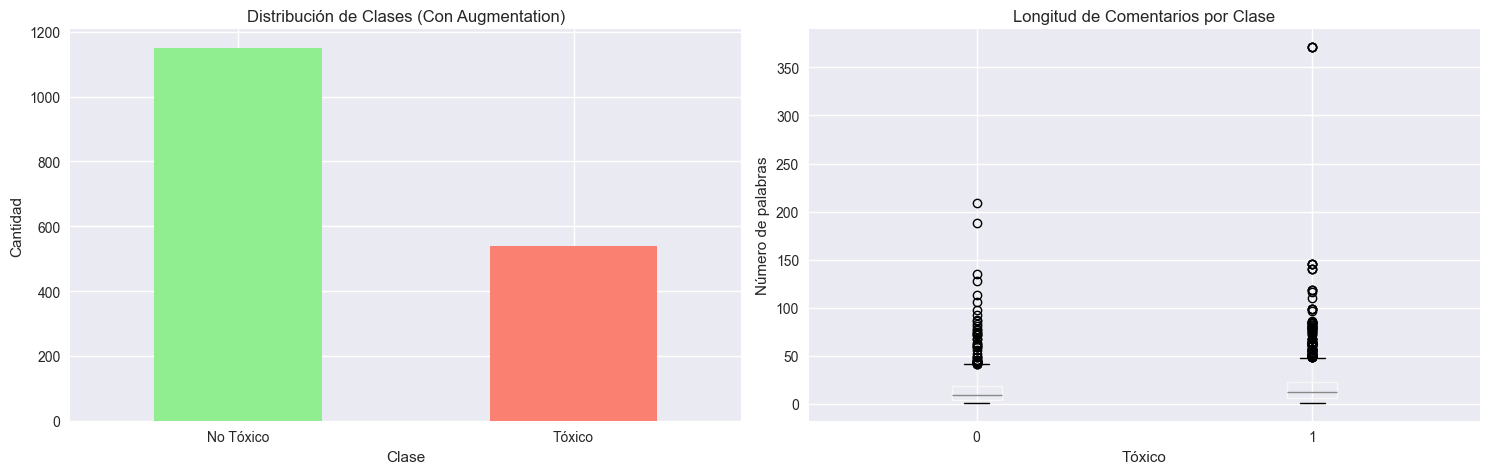

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Balance de clases
df_final['toxic_binary'].value_counts().plot(kind='bar', ax=axes[0], 
                                            color=['lightgreen', 'salmon'])
axes[0].set_title('Distribución de Clases (Con Augmentation)')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')
axes[0].set_xticklabels(['No Tóxico', 'Tóxico'], rotation=0)

# Longitud de comentarios
df_final['longitud'] = df_final['texto_procesado'].str.split().str.len()
df_final.boxplot(column='longitud', by='toxic_binary', ax=axes[1])
axes[1].set_title('Longitud de Comentarios por Clase')
axes[1].set_xlabel('Tóxico')
axes[1].set_ylabel('Número de palabras')
plt.suptitle('')

plt.tight_layout()
plt.show()

# WORDCLOUDS COMPARATIVOS


📊 WORDCLOUDS COMPARATIVOS
   • Comentarios tóxicos para WordCloud: 1150
   • Comentarios no tóxicos para WordCloud: 538
   • Palabras en corpus tóxico: 23221
   • Palabras en corpus no tóxico: 8785


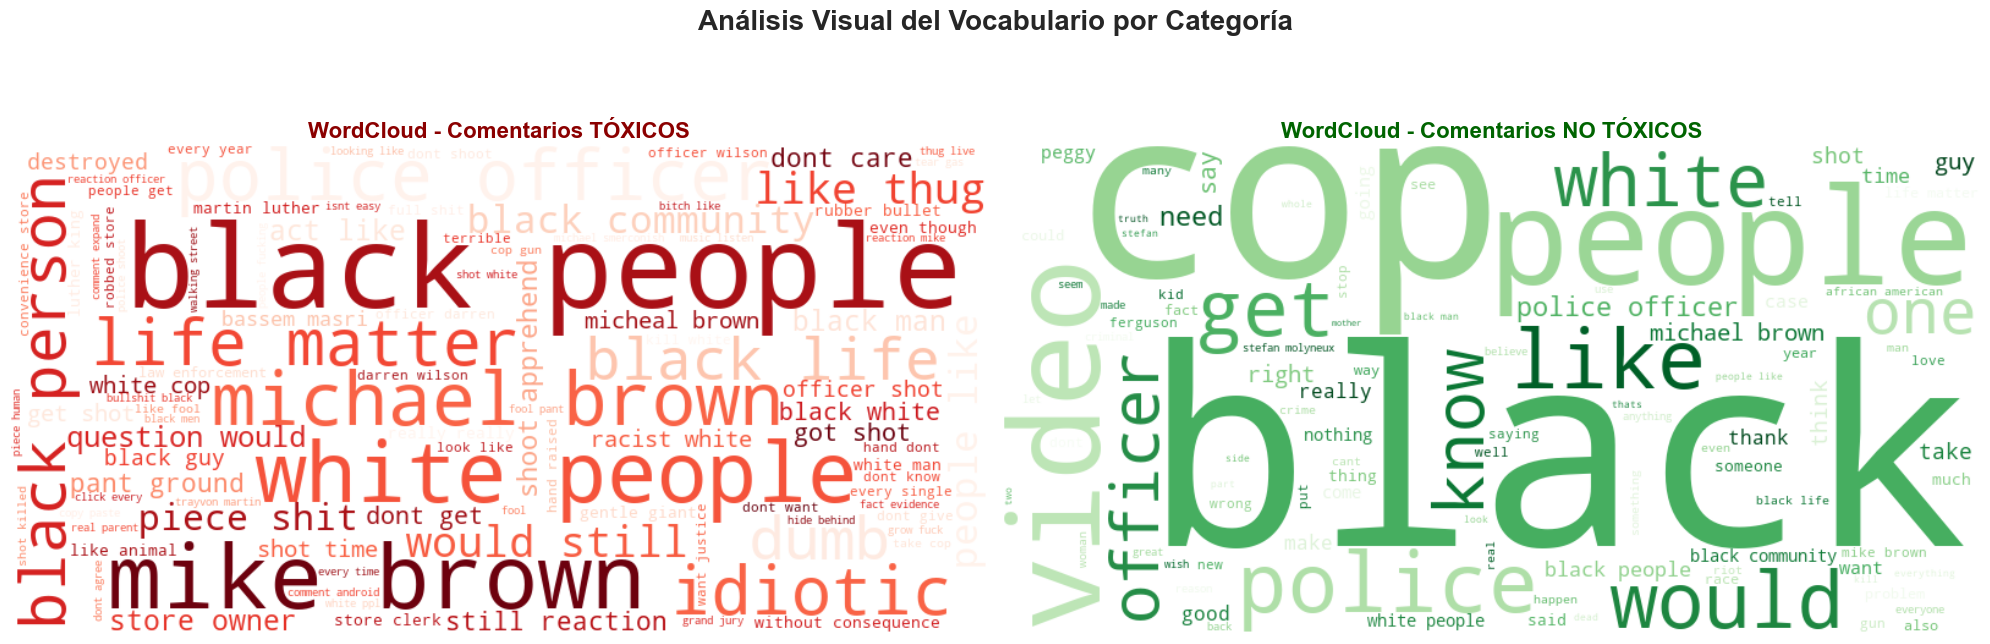

In [9]:
print("\n📊 WORDCLOUDS COMPARATIVOS")

# Separar textos por categoría usando los datos procesados
textos_toxicos = df_final[df_final['toxic_binary'] == 1]['texto_procesado']
textos_no_toxicos = df_final[df_final['toxic_binary'] == 0]['texto_procesado']

print(f"   • Comentarios tóxicos para WordCloud: {len(textos_toxicos)}")
print(f"   • Comentarios no tóxicos para WordCloud: {len(textos_no_toxicos)}")

# Combinar textos por categoría
texto_toxico_combinado = ' '.join(textos_toxicos.dropna())
texto_no_toxico_combinado = ' '.join(textos_no_toxicos.dropna())

print(f"   • Palabras en corpus tóxico: {len(texto_toxico_combinado.split())}")
print(f"   • Palabras en corpus no tóxico: {len(texto_no_toxico_combinado.split())}")

# Verificar que tenemos suficiente texto
if len(texto_toxico_combinado.split()) < 10:
    print("⚠️ Advertencia: Poco texto tóxico disponible para WordCloud")
if len(texto_no_toxico_combinado.split()) < 10:
    print("⚠️ Advertencia: Poco texto no tóxico disponible para WordCloud")

# Generar WordClouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Configuración común para ambos WordClouds
wordcloud_config = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'max_words': 100,
    'relative_scaling': 0.5,
    'stopwords': stop_words,  # Usar las mismas stopwords del preprocesamiento
    'collocation_threshold': 10
}

# WordCloud para comentarios tóxicos
if len(texto_toxico_combinado.strip()) > 0:
    wordcloud_toxico = WordCloud(
        **wordcloud_config,
        colormap='Reds'
    ).generate(texto_toxico_combinado)
    
    axes[0].imshow(wordcloud_toxico, interpolation='bilinear')
    axes[0].set_title('WordCloud - Comentarios TÓXICOS', fontweight='bold', fontsize=16, color='darkred')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'No hay suficiente\ntexto tóxico', 
                ha='center', va='center', transform=axes[0].transAxes, fontsize=16)
    axes[0].set_title('WordCloud - Comentarios TÓXICOS', fontweight='bold', fontsize=16, color='darkred')

# WordCloud para comentarios no tóxicos
if len(texto_no_toxico_combinado.strip()) > 0:
    wordcloud_no_toxico = WordCloud(
        **wordcloud_config,
        colormap='Greens'
    ).generate(texto_no_toxico_combinado)
    
    axes[1].imshow(wordcloud_no_toxico, interpolation='bilinear')
    axes[1].set_title('WordCloud - Comentarios NO TÓXICOS', fontweight='bold', fontsize=16, color='darkgreen')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'No hay suficiente\ntexto no tóxico', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=16)
    axes[1].set_title('WordCloud - Comentarios NO TÓXICOS', fontweight='bold', fontsize=16, color='darkgreen')

plt.suptitle('Análisis Visual del Vocabulario por Categoría', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# 8. PREPARACIÓN PARA MACHINE LEARNING

In [10]:
print("\n🎯 Preparando datos para entrenamiento...")

# Features y target
X = df_final['texto_procesado']
y = df_final['toxic_binary']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 División de datos:")
print(f"   - Entrenamiento: {len(X_train)} ({y_train.mean()*100:.1f}% tóxicos)")
print(f"   - Prueba: {len(X_test)} ({y_test.mean()*100:.1f}% tóxicos)")


🎯 Preparando datos para entrenamiento...
📊 División de datos:
   - Entrenamiento: 1350 (68.1% tóxicos)
   - Prueba: 338 (68.0% tóxicos)


# 9. VECTORIZACIÓN OPTIMIZADA

In [11]:
print("\n🔢 Vectorizando con TF-IDF...")

vectorizer = TfidfVectorizer(
    max_features=2000,      # Más features por más datos
    ngram_range=(1, 3),     # Incluir trigramas
    min_df=2,               # Mínima frecuencia
    max_df=0.95,            # Máxima frecuencia
    sublinear_tf=True,      # Escalado logarítmico
    use_idf=True,           # IDF para ponderar importancia
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"✅ Forma de datos vectorizados: {X_train_vec.shape}")


🔢 Vectorizando con TF-IDF...
✅ Forma de datos vectorizados: (1350, 2000)


# 10. ENTRENAMIENTO DE XGBOOST

In [12]:
print("\n🚀 Entrenando XGBoost optimizado...")

# Calcular peso de clases para balanceo
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Modelo XGBoost con hiperparámetros optimizados
modelo = xgb.XGBClassifier(
    # Parámetros básicos
    n_estimators=300,           # Número de árboles
    max_depth=6,                # Profundidad máxima
    learning_rate=0.1,          # Tasa de aprendizaje
    
    # Control de overfitting
    subsample=0.8,              # Submuestreo de filas
    colsample_bytree=0.8,       # Submuestreo de columnas
    reg_alpha=0.1,              # Regularización L1
    reg_lambda=1.0,             # Regularización L2
    
    # Balanceo de clases
    scale_pos_weight=scale_pos_weight,
    
    # Otros parámetros
    objective='binary:logistic',
    eval_metric=['error', 'logloss'],  # Métricas de evaluación
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,                  # Usar todos los cores
    early_stopping_rounds=20    # Early stopping
)

# Entrenar con conjunto de validación
eval_set = [(X_train_vec, y_train), (X_test_vec, y_test)]
modelo.fit(
    X_train_vec, y_train,
    eval_set=eval_set,
    verbose=False
)

# Obtener información del entrenamiento
resultado_entrenamiento = modelo.evals_result()
if resultado_entrenamiento:
    # Obtener el mejor score de la validación
    val_scores = resultado_entrenamiento['validation_1']['logloss']
    mejor_iteracion = np.argmin(val_scores)
    mejor_score = val_scores[mejor_iteracion]
    print(f"✅ Mejor iteración: {mejor_iteracion + 1}")
    print(f"✅ Mejor score (logloss): {mejor_score:.4f}")

# Validación cruzada con modelo sin early stopping
print("\n📈 Realizando validación cruzada...")
modelo_cv = xgb.XGBClassifier(
    n_estimators=100,  # Menos árboles para CV rápida
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

scores_cv = cross_val_score(modelo_cv, X_train_vec, y_train, cv=5, scoring='f1')
print(f"   - F1-Scores: {[f'{s:.3f}' for s in scores_cv]}")
print(f"   - Media: {scores_cv.mean():.3f} (+/- {scores_cv.std() * 2:.3f})")


🚀 Entrenando XGBoost optimizado...
✅ Mejor iteración: 261
✅ Mejor score (logloss): 0.4017

📈 Realizando validación cruzada...
   - F1-Scores: ['0.779', '0.810', '0.746', '0.780', '0.799']
   - Media: 0.783 (+/- 0.043)


# 11. EVALUACIÓN DETALLADA


📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:

🎯 Métricas principales:
   - Accuracy: 0.840
   - F1-Score: 0.879

📋 Reporte de clasificación:
              precision    recall  f1-score   support

   No Tóxico      0.725     0.806     0.763       108
      Tóxico      0.904     0.857     0.879       230

    accuracy                          0.840       338
   macro avg      0.814     0.831     0.821       338
weighted avg      0.847     0.840     0.842       338



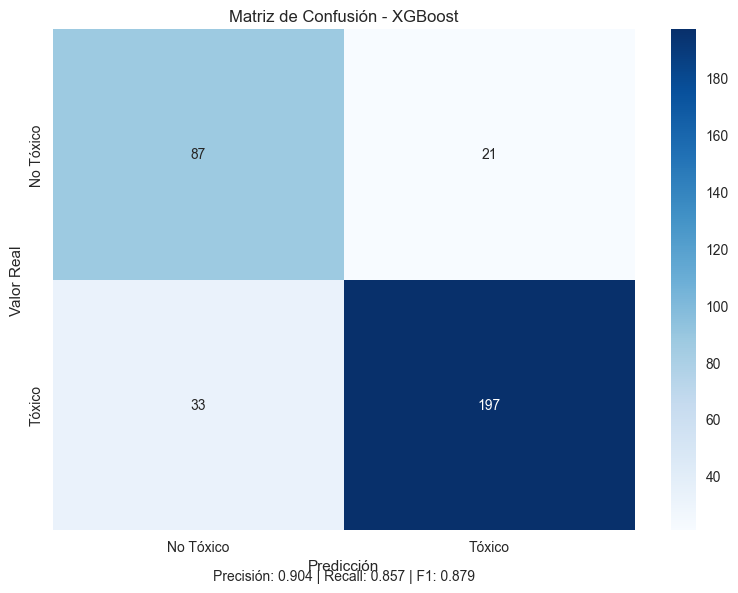

In [13]:
print("\n📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:")

# Predicciones
y_pred = modelo.predict(X_test_vec)
y_pred_proba = modelo.predict_proba(X_test_vec)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n🎯 Métricas principales:")
print(f"   - Accuracy: {accuracy:.3f}")
print(f"   - F1-Score: {f1:.3f}")

# Reporte completo
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Tóxico', 'Tóxico'],
                          digits=3))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tóxico', 'Tóxico'],
            yticklabels=['No Tóxico', 'Tóxico'])
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')

# Agregar métricas en el título
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
plt.text(0.5, -0.1, f'Precisión: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}', 
         ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 12. ANÁLISIS DE IMPORTANCIA DE FEATURES


🔤 ANÁLISIS DE IMPORTANCIA DE FEATURES:

🏆 Top 20 features más importantes:
   'fuck': 0.0230
   'single': 0.0190
   'something': 0.0142
   'drug': 0.0136
   'shit': 0.0119
   'as': 0.0118
   'dumb': 0.0111
   'thug': 0.0109
   'fucking': 0.0109
   'peggy': 0.0100
   'video': 0.0098
   'shoot': 0.0095
   'white people': 0.0095
   'idiot': 0.0093
   'black': 0.0089
   'moron': 0.0087
   'truth': 0.0085
   'stupid': 0.0084
   'officer': 0.0084
   'bitch': 0.0081


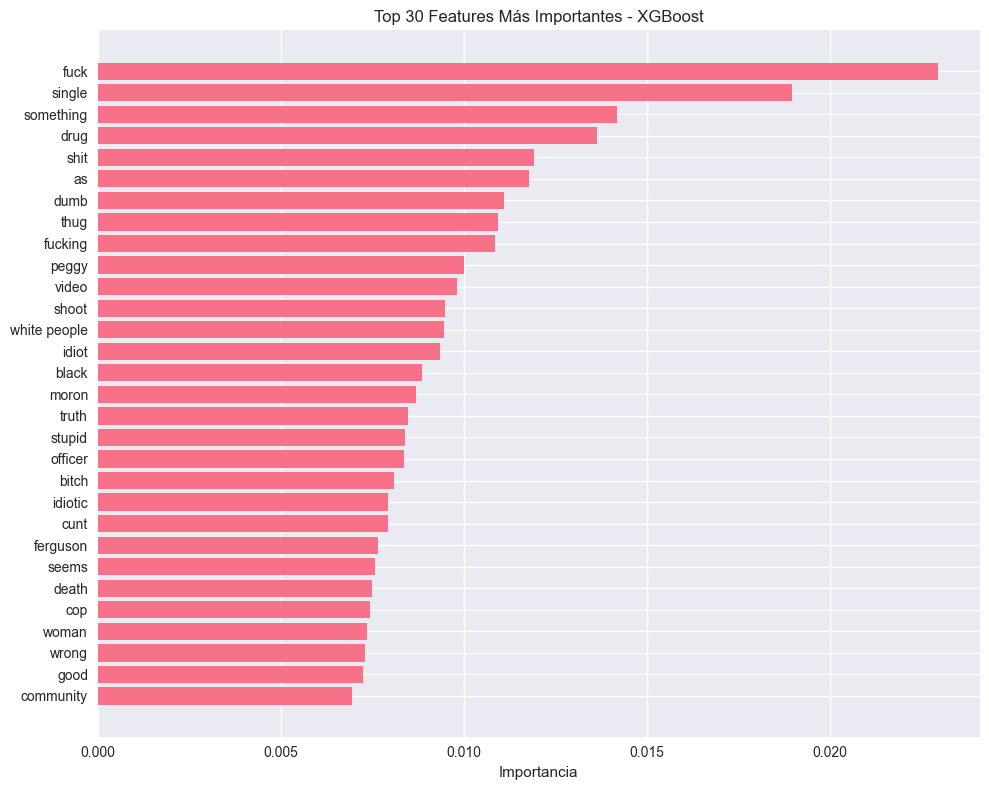


📊 Análisis detallado de importancia:

WEIGHT:
   'people': 73.0000
   'black': 51.0000
   'would': 44.0000
   'cop': 40.0000
   'brown': 38.0000
   'police': 38.0000
   'shot': 34.0000
   'fuck': 32.0000
   'like': 32.0000
   'guy': 31.0000

GAIN:
   'fuck': 7.8755
   'single': 6.5068
   'something': 4.8686
   'drug': 4.6799
   'shit': 4.0919
   'as': 4.0402
   'dumb': 3.8095
   'thug': 3.7523
   'fucking': 3.7281
   'peggy': 3.4303

COVER:
   'fuck': 134.8586
   'cunt': 132.4411
   'as': 128.5845
   'fucking': 128.5261
   'dumb': 128.4083
   'isnt': 127.5189
   'idiotic': 126.9651
   'bitch': 124.9560
   'road': 124.9452
   'peggy': 124.4507


In [14]:
print("\n🔤 ANÁLISIS DE IMPORTANCIA DE FEATURES:")

# Obtener importancia de features de XGBoost
feature_names = vectorizer.get_feature_names_out()
importancias = modelo.feature_importances_

# Crear DataFrame de importancias
df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias
}).sort_values('importance', ascending=False)

# Top 20 features más importantes
print("\n🏆 Top 20 features más importantes:")
for idx, row in df_importancia.head(20).iterrows():
    print(f"   '{row['feature']}': {row['importance']:.4f}")

# Visualizar importancia de features
plt.figure(figsize=(10, 8))
top_features = df_importancia.head(30)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 30 Features Más Importantes - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Análisis adicional: Gain vs Cover
if hasattr(modelo, 'get_booster'):
    print("\n📊 Análisis detallado de importancia:")
    importance_types = ['weight', 'gain', 'cover']
    
    for imp_type in importance_types:
        importances_dict = modelo.get_booster().get_score(importance_type=imp_type)
        if importances_dict:
            print(f"\n{imp_type.upper()}:")
            sorted_imp = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)[:10]
            for feat, score in sorted_imp:
                if feat.startswith('f'):
                    feat_idx = int(feat[1:])
                    feat_name = feature_names[feat_idx]
                    print(f"   '{feat_name}': {score:.4f}")

# 13. FUNCIÓN DE PREDICCIÓN

In [15]:
def predecir_toxicidad(texto, modelo=modelo, vectorizer=vectorizer):
    """
    Predice si un comentario es tóxico.
    
    Retorna:
    - etiqueta: 'TÓXICO' o 'NO TÓXICO'
    - confianza: probabilidad de la predicción
    """
    # Preprocesar
    texto_limpio = limpiar_texto(texto)
    texto_procesado = procesar_texto(texto_limpio)
    
    # Vectorizar
    texto_vec = vectorizer.transform([texto_procesado])
    
    # Predecir
    prediccion = modelo.predict(texto_vec)[0]
    probabilidad = modelo.predict_proba(texto_vec)[0, 1]
    
    etiqueta = "TÓXICO ⚠️" if prediccion == 1 else "NO TÓXICO ✅"
    confianza = probabilidad if prediccion == 1 else (1 - probabilidad)
    
    return etiqueta, confianza

# Probar con ejemplos
print("\n🧪 PRUEBAS CON COMENTARIOS NUEVOS:")

ejemplos = [
    "Great video, thanks for sharing!",
    "You're so stupid and ignorant",
    "I disagree with your opinion",
    "This is garbage content, delete it",
    "Interesting perspective, never thought about it that way"
]

for comentario in ejemplos:
    etiqueta, confianza = predecir_toxicidad(comentario)
    print(f"\n📝 '{comentario}'")
    print(f"   → {etiqueta} (Confianza: {confianza:.1%})")


🧪 PRUEBAS CON COMENTARIOS NUEVOS:

📝 'Great video, thanks for sharing!'
   → NO TÓXICO ✅ (Confianza: 89.5%)

📝 'You're so stupid and ignorant'
   → TÓXICO ⚠️ (Confianza: 77.6%)

📝 'I disagree with your opinion'
   → NO TÓXICO ✅ (Confianza: 60.7%)

📝 'This is garbage content, delete it'
   → NO TÓXICO ✅ (Confianza: 60.7%)

📝 'Interesting perspective, never thought about it that way'
   → NO TÓXICO ✅ (Confianza: 83.4%)


# 14. GUARDAR MODELO Y COMPONENTES

In [16]:
print("\n💾 GUARDANDO MODELO Y COMPONENTES...")

# Nombres de archivo
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
archivo_modelo = f'modelo_toxicidad_xgboost_{timestamp}.pkl'
archivo_vectorizer = f'vectorizer_toxicidad_{timestamp}.pkl'

# Guardar versiones
with open('modelo_toxicidad_xgboost_final.pkl', 'wb') as f:
    pickle.dump(modelo, f)

with open('vectorizer_toxicidad_final.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print(f"✅ Modelo XGBoost guardado como: {archivo_modelo}")
print(f"✅ Vectorizador guardado como: {archivo_vectorizer}")
print(f"✅ También guardados como: modelo_toxicidad_xgboost_final.pkl y vectorizer_toxicidad_final.pkl")


💾 GUARDANDO MODELO Y COMPONENTES...
✅ Modelo XGBoost guardado como: modelo_toxicidad_xgboost_20250707_095011.pkl
✅ Vectorizador guardado como: vectorizer_toxicidad_20250707_095011.pkl
✅ También guardados como: modelo_toxicidad_xgboost_final.pkl y vectorizer_toxicidad_final.pkl


# ANÁLISIS DE OVERFITTING


🔍 ANÁLISIS DE OVERFITTING

📊 COMPARACIÓN DE MÉTRICAS POR CONJUNTO:
----------------------------------------

Entrenamiento:
  ACCURACY: 0.9163
  PRECISION: 0.9915
  RECALL: 0.8848
  F1: 0.9351
  AUC: 0.9866

Prueba:
  ACCURACY: 0.8402
  PRECISION: 0.9037
  RECALL: 0.8565
  F1: 0.8795
  AUC: 0.8849

🚨 DETECCIÓN DE OVERFITTING:
------------------------------
📈 F1 Train vs Test: 0.0556
⚠️  OVERFITTING MODERADO detectado (Train >> Test)

📊 GENERANDO VISUALIZACIONES...
📈 Calculando curvas de aprendizaje...


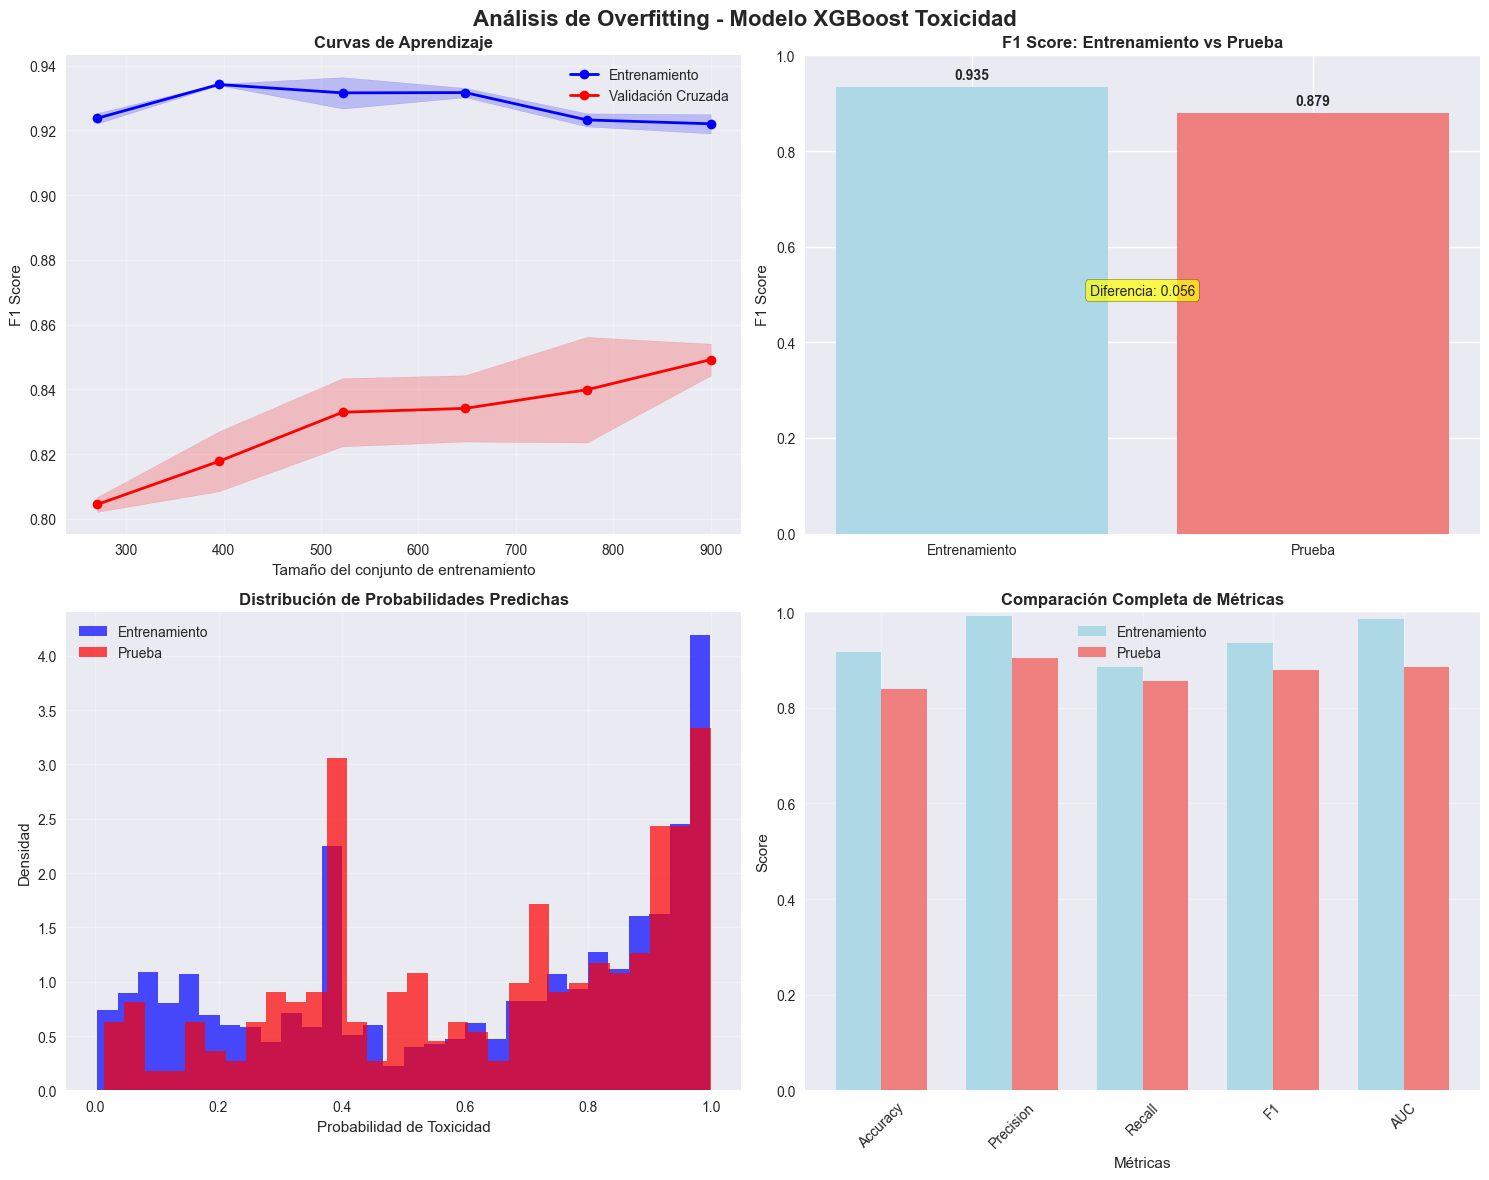


📋 REPORTE FINAL DE OVERFITTING
📊 ANÁLISIS DETALLADO:
   • F1 Entrenamiento: 0.9351
   • F1 Prueba:        0.8795

🔍 GAP DE RENDIMIENTO:
   • Train-Test gap:   0.0556

🩺 DIAGNÓSTICO:
   ⚠️  MODERADO: Overfitting detectado

💡 RECOMENDACIÓN:
   Considerar más regularización o early stopping más agresivo

🎯 CAPACIDAD DE GENERALIZACIÓN: 16.6/100 🟠
   👎 GENERALIZACIÓN BAJA - Hay overfitting, revisar modelo

🎯 ANÁLISIS ESPECÍFICO PARA TOXICIDAD:
   • Gap Precision: 0.0878
   • Gap Recall:    0.0283

✅ ANÁLISIS DE OVERFITTING COMPLETADO

📈 ANÁLISIS ADICIONAL: DISTRIBUCIÓN DE CONFIANZA
--------------------------------------------------
📊 Distribución de confianza en predicciones de prueba:
   • Alta confianza (>80% o <20%):  161 (47.6%)
   • Media confianza (60-80%, 20-40%): 134 (39.6%)
   • Baja confianza (40-60%):        43 (12.7%)

🎯 Accuracy por nivel de confianza:
   • Alta confianza: 0.938
   • Media confianza: 0.791
   • Baja confianza: 0.628

💡 Interpretación:
   ✅ Modelo hace predicci

In [17]:
def analizar_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test):
    """
    Análisis completo de overfitting del modelo XGBoost
    Adaptado para el notebook de detección de toxicidad
    """
    
    print("🔍 ANÁLISIS DE OVERFITTING")
    print("=" * 50)
    
    # 1. MÉTRICAS COMPARATIVAS ENTRE CONJUNTOS
    print("\n📊 COMPARACIÓN DE MÉTRICAS POR CONJUNTO:")
    print("-" * 40)
    
    conjuntos_datos = {
        'Entrenamiento': (X_train_vec, y_train),
        'Prueba': (X_test_vec, y_test)
    }
    
    comparacion_metricas = {}
    
    for nombre, (X, y) in conjuntos_datos.items():
        y_pred = modelo_xgb.predict(X)
        y_proba = modelo_xgb.predict_proba(X)[:, 1]
        
        metricas = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'auc': roc_auc_score(y, y_proba)
        }
        
        comparacion_metricas[nombre] = metricas
        
        print(f"\n{nombre}:")
        for metrica, valor in metricas.items():
            print(f"  {metrica.upper()}: {valor:.4f}")
    
    # 2. DETECTAR OVERFITTING
    print(f"\n🚨 DETECCIÓN DE OVERFITTING:")
    print("-" * 30)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # Diferencias
    train_test_diff = train_f1 - test_f1
    
    print(f"📈 F1 Train vs Test: {train_test_diff:.4f}")
    
    # Análisis de overfitting
    overfitting_detectado = False
    
    if train_test_diff > 0.08:  # Más de 8% de diferencia es preocupante
        print("❌ OVERFITTING SEVERO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.05:  # Más de 5% de diferencia
        print("⚠️  OVERFITTING MODERADO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.02:  # Ligero overfitting
        print("⚠️  LIGERO OVERFITTING detectado")
        overfitting_detectado = True
    
    if not overfitting_detectado:
        print("✅ NO se detecta overfitting significativo")
        print("✅ Modelo tiene buena generalización")
    
    return comparacion_metricas

def graficar_analisis_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas):
    """
    Visualizaciones para análisis de overfitting
    Adaptado para el modelo XGBoost del notebook
    """
    
    print(f"\n📊 GENERANDO VISUALIZACIONES...")
    
    # Crear subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análisis de Overfitting - Modelo XGBoost Toxicidad', fontsize=16, fontweight='bold')
    
    # Subplot 1: Curvas de aprendizaje
    print("📈 Calculando curvas de aprendizaje...")
    
    # Crear un modelo XGBoost sin early stopping para las curvas de aprendizaje
    modelo_sin_early_stopping = xgb.XGBClassifier(
        n_estimators=100,  # Menos árboles para ser más rápido
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
        # NO incluir early_stopping_rounds aquí
    )
    
    train_sizes, train_scores, val_scores = learning_curve(
        modelo_sin_early_stopping, X_train_vec, y_train,
        cv=3, 
        train_sizes=np.linspace(0.3, 1.0, 6),  # Empezar con más datos para evitar problemas
        scoring='f1',
        n_jobs=-1
    )
    
    # Calcular medias y desviaciones
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[0, 0].plot(train_sizes, train_mean, 'o-', color='blue', label='Entrenamiento', linewidth=2)
    axes[0, 0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    axes[0, 0].plot(train_sizes, val_mean, 'o-', color='red', label='Validación Cruzada', linewidth=2)
    axes[0, 0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    axes[0, 0].set_xlabel('Tamaño del conjunto de entrenamiento')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title('Curvas de Aprendizaje', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: Comparación de métricas Train vs Test
    conjuntos = ['Entrenamiento', 'Prueba']
    f1_scores = [
        comparacion_metricas['Entrenamiento']['f1'],
        comparacion_metricas['Prueba']['f1']
    ]
    
    colores = ['lightblue', 'lightcoral']
    barras = axes[0, 1].bar(conjuntos, f1_scores, color=colores)
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1 Score: Entrenamiento vs Prueba', fontweight='bold')
    axes[0, 1].set_ylim(0, 1)
    
    # Añadir valores en las barras
    for barra, score in zip(barras, f1_scores):
        axes[0, 1].text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.01,
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Línea de referencia para mostrar la diferencia
    diferencia = abs(f1_scores[0] - f1_scores[1])
    axes[0, 1].text(0.5, 0.5, f'Diferencia: {diferencia:.3f}', 
                   transform=axes[0, 1].transAxes, ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Subplot 3: Distribución de probabilidades por conjunto
    y_proba_train = modelo_xgb.predict_proba(X_train_vec)[:, 1]
    y_proba_test = modelo_xgb.predict_proba(X_test_vec)[:, 1]
    
    axes[1, 0].hist(y_proba_train, bins=30, alpha=0.7, label='Entrenamiento', color='blue', density=True)
    axes[1, 0].hist(y_proba_test, bins=30, alpha=0.7, label='Prueba', color='red', density=True)
    axes[1, 0].set_xlabel('Probabilidad de Toxicidad')
    axes[1, 0].set_ylabel('Densidad')
    axes[1, 0].set_title('Distribución de Probabilidades Predichas', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Subplot 4: Todas las métricas comparadas
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    train_metricas = [comparacion_metricas['Entrenamiento'][m.lower()] for m in metricas]
    test_metricas = [comparacion_metricas['Prueba'][m.lower()] for m in metricas]
    
    x = np.arange(len(metricas))
    ancho = 0.35
    
    axes[1, 1].bar(x - ancho/2, train_metricas, ancho, label='Entrenamiento', color='lightblue')
    axes[1, 1].bar(x + ancho/2, test_metricas, ancho, label='Prueba', color='lightcoral')
    
    axes[1, 1].set_xlabel('Métricas')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Comparación Completa de Métricas', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metricas, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def generar_reporte_overfitting(comparacion_metricas):
    """
    Generar reporte final de overfitting
    """
    
    print(f"\n📋 REPORTE FINAL DE OVERFITTING")
    print("=" * 50)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # Análisis detallado
    print(f"📊 ANÁLISIS DETALLADO:")
    print(f"   • F1 Entrenamiento: {train_f1:.4f}")
    print(f"   • F1 Prueba:        {test_f1:.4f}")
    
    gap_train_test = train_f1 - test_f1
    
    print(f"\n🔍 GAP DE RENDIMIENTO:")
    print(f"   • Train-Test gap:   {gap_train_test:.4f}")
    
    # Diagnóstico
    print(f"\n🩺 DIAGNÓSTICO:")
    
    if gap_train_test < 0.02:
        print("   ✅ EXCELENTE: Modelo muy bien generalizado")
        recomendacion = "El modelo está listo para producción"
        color_estado = "🟢"
        
    elif gap_train_test < 0.05:
        print("   ✅ BUENO: Ligero overfitting, pero aceptable")
        recomendacion = "Modelo aceptable para producción con monitoreo"
        color_estado = "🟡"
        
    elif gap_train_test < 0.08:
        print("   ⚠️  MODERADO: Overfitting detectado")
        recomendacion = "Considerar más regularización o early stopping más agresivo"
        color_estado = "🟠"
        
    else:
        print("   ❌ SEVERO: Overfitting significativo")
        recomendacion = "Necesario ajustar hiperparámetros o reentrenar"
        color_estado = "🔴"
    
    print(f"\n💡 RECOMENDACIÓN:")
    print(f"   {recomendacion}")
    
    # Métricas de generalización (no "confianza" para evitar confusión)
    puntaje_generalizacion = max(0, 100 - (gap_train_test * 100 * 15))
    print(f"\n🎯 CAPACIDAD DE GENERALIZACIÓN: {puntaje_generalizacion:.1f}/100 {color_estado}")
    
    if puntaje_generalizacion >= 85:
        print("   🏆 EXCELENTE generalización - Modelo muy robusto")
    elif puntaje_generalizacion >= 70:
        print("   👍 BUENA generalización - Modelo confiable")
    elif puntaje_generalizacion >= 50:
        print("   ⚠️  GENERALIZACIÓN MEDIA - Modelo aceptable con reservas")
    else:
        print("   👎 GENERALIZACIÓN BAJA - Hay overfitting, revisar modelo")
    
    # Análisis adicional específico para detección de toxicidad
    print(f"\n🎯 ANÁLISIS ESPECÍFICO PARA TOXICIDAD:")
    
    train_precision = comparacion_metricas['Entrenamiento']['precision']
    test_precision = comparacion_metricas['Prueba']['precision']
    precision_gap = train_precision - test_precision
    
    train_recall = comparacion_metricas['Entrenamiento']['recall']
    test_recall = comparacion_metricas['Prueba']['recall']
    recall_gap = train_recall - test_recall
    
    print(f"   • Gap Precision: {precision_gap:.4f}")
    print(f"   • Gap Recall:    {recall_gap:.4f}")
    
    if precision_gap > 0.1:
        print("   ⚠️  Modelo podría estar generando muchos falsos positivos en producción")
    if recall_gap > 0.1:
        print("   ⚠️  Modelo podría estar perdiendo comentarios tóxicos en producción")

# EJECUTAR ANÁLISIS COMPLETO DE OVERFITTING
# 1. Analizar overfitting con las métricas
comparacion_metricas = analizar_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test
)

# 2. Generar visualizaciones
graficar_analisis_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas
)

# 3. Generar reporte final
generar_reporte_overfitting(comparacion_metricas)

print(f"\n✅ ANÁLISIS DE OVERFITTING COMPLETADO")
print("="*70)

# ANÁLISIS ADICIONAL: PREDICCIONES POR CONFIANZA
print(f"\n📈 ANÁLISIS ADICIONAL: DISTRIBUCIÓN DE CONFIANZA")
print("-" * 50)

# Analizar las predicciones por nivel de confianza
y_proba_test = modelo.predict_proba(X_test_vec)[:, 1]

# Categorizar predicciones por confianza
alta_confianza = (y_proba_test >= 0.8) | (y_proba_test <= 0.2)
media_confianza = ((y_proba_test >= 0.6) & (y_proba_test < 0.8)) | ((y_proba_test > 0.2) & (y_proba_test <= 0.4))
baja_confianza = (y_proba_test > 0.4) & (y_proba_test < 0.6)

print(f"📊 Distribución de confianza en predicciones de prueba:")
print(f"   • Alta confianza (>80% o <20%):  {alta_confianza.sum():3d} ({alta_confianza.mean()*100:.1f}%)")
print(f"   • Media confianza (60-80%, 20-40%): {media_confianza.sum():3d} ({media_confianza.mean()*100:.1f}%)")
print(f"   • Baja confianza (40-60%):       {baja_confianza.sum():3d} ({baja_confianza.mean()*100:.1f}%)")

# Calcular accuracy por nivel de confianza
if alta_confianza.sum() > 0:
    acc_alta = accuracy_score(y_test[alta_confianza], (y_proba_test[alta_confianza] > 0.5))
    print(f"\n🎯 Accuracy por nivel de confianza:")
    print(f"   • Alta confianza: {acc_alta:.3f}")

if media_confianza.sum() > 0:
    acc_media = accuracy_score(y_test[media_confianza], (y_proba_test[media_confianza] > 0.5))
    print(f"   • Media confianza: {acc_media:.3f}")

if baja_confianza.sum() > 0:
    acc_baja = accuracy_score(y_test[baja_confianza], (y_proba_test[baja_confianza] > 0.5))
    print(f"   • Baja confianza: {acc_baja:.3f}")

print(f"\n💡 Interpretación:")
if baja_confianza.mean() < 0.15:  # Menos del 15% de predicciones inciertas
    print("   ✅ Modelo hace predicciones con alta certeza individual")
    print("   📊 La mayoría de predicciones son muy seguras (>80% o <20%)")
else:
    print("   ⚠️  Considerable número de predicciones con baja certeza")
    print("   📊 Muchas predicciones están en zona gris (40-60%)")

print(f"\n🏁 ANÁLISIS COMPLETO FINALIZADO")
print("="*70)

# 15. RESUMEN FINAL

In [19]:
print("\n" + "="*60)
print("🎉 RESUMEN DEL PROYECTO")
print("="*60)

print(f"""
📊 Dataset:
   - Comentarios originales: 1,000
   - Después de augmentation: {len(df_final)}
   - Balance final: {df_final['toxic_binary'].mean()*100:.1f}% tóxicos

🧹 Preprocesamiento:
   - Columnas eliminadas: {len(columnas_eliminar)} (desbalanceadas)
   - Columnas usadas: {len(columnas_mantener)}
   - Técnica: Limpieza + Lemmatización

🔄 Data Augmentation:
   - Método: Variaciones de texto
   - Comentarios tóxicos aumentados: {len(df_aumentados)}

🤖 Modelo:
   - Algoritmo: XGBoost
   - Parámetros: 300 árboles, profundidad 6, early stopping
   - Vectorización: TF-IDF (2000 features, n-gramas 1-3)
   - Performance: F1-Score = {f1:.3f}

✅ Archivos generados:
   - dataset_toxicidad_aumentado.csv
   - modelo_toxicidad_xgboost_final.pkl
   - vectorizer_toxicidad_final.pkl
""")


🎉 RESUMEN DEL PROYECTO

📊 Dataset:
   - Comentarios originales: 1,000
   - Después de augmentation: 1688
   - Balance final: 68.1% tóxicos

🧹 Preprocesamiento:
   - Columnas eliminadas: 6 (desbalanceadas)
   - Columnas usadas: 5
   - Técnica: Limpieza + Lemmatización

🔄 Data Augmentation:
   - Método: Variaciones de texto
   - Comentarios tóxicos aumentados: 688

🤖 Modelo:
   - Algoritmo: XGBoost
   - Parámetros: 300 árboles, profundidad 6, early stopping
   - Vectorización: TF-IDF (2000 features, n-gramas 1-3)
   - Performance: F1-Score = 0.879

✅ Archivos generados:
   - dataset_toxicidad_aumentado.csv
   - modelo_toxicidad_xgboost_final.pkl
   - vectorizer_toxicidad_final.pkl

